# Pretrain Stuff

In [1]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedKFold, cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filepath = '/content/drive/MyDrive/STUDIUM/Studium 2022 FS/Machine Learning/Projects/Project 4/'

In [4]:
pretrain_features = pd.read_csv(filepath + '/pretrain_features.csv')
pretrain_labels = pd.read_csv(filepath + './pretrain_labels.csv')
X_pretrain = pretrain_features.drop(['Id', 'smiles'], axis=1)
y_pretrain = pretrain_labels.drop(['Id'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_pretrain, y_pretrain, test_size=0.1, random_state=42, shuffle=True)

Epoch 1/80
405/405 [==============================] - 4s 3ms/step - loss: 0.7569 - root_mean_squared_error: 0.4357 - val_loss: 0.2367 - val_root_mean_squared_error: 0.1608
Epoch 2/80
405/405 [==============================] - 1s 3ms/step - loss: 0.1352 - root_mean_squared_error: 0.1332 - val_loss: 0.0729 - val_root_mean_squared_error: 0.1168
Epoch 3/80
405/405 [==============================] - 1s 3ms/step - loss: 0.0458 - root_mean_squared_error: 0.1020 - val_loss: 0.0292 - val_root_mean_squared_error: 0.0994
Epoch 4/80
405/405 [==============================] - 1s 3ms/step - loss: 0.0200 - root_mean_squared_error: 0.0878 - val_loss: 0.0156 - val_root_mean_squared_error: 0.0907
Epoch 5/80
405/405 [==============================] - 1s 3ms/step - loss: 0.0115 - root_mean_squared_error: 0.0790 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0944
Epoch 6/80
405/405 [==============================] - 1s 3ms/step - loss: 0.0084 - root_mean_squared_error: 0.0741 - val_loss: 0.0090 - val_

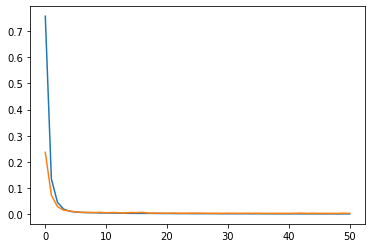

In [ ]:
layer1 = Dense(units=128, input_shape=(X_pretrain.shape[1],), activation='relu')
layer2 = Dense(units=128, activation='relu', kernel_regularizer='l2')
layer3 = Dense(units=1)
transferModel = Sequential([layer1,layer2,layer3])

transferModel.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = transferModel.fit(X_train, y_train, epochs=80, batch_size=100, validation_split=0.1, callbacks=[es])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
y_pred = transferModel.predict(X_test)
mean_squared_error(y_test,y_pred, squared=False)

0.05679034551519653

In [ ]:
transferModel.save(filepath+'transfermodel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/STUDIUM/Studium 2022 FS/Machine Learning/Projects/Project 4/transfermodel/assets


# Homo-Lumo Stuff

In [5]:
base_net = tf.keras.models.load_model(filepath+'transfermodel')
base_net.trainable = False
base_net.layers.pop()
base_net = Model(base_net.input, base_net.layers[-2].output)
base_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
Total params: 144,640
Trainable params: 0
Non-trainable params: 144,640
_________________________________________________________________


In [ ]:
train_features = pd.read_csv(filepath + '/train_features.csv')
train_labels = pd.read_csv(filepath + './train_labels.csv')
X = train_features.drop(['Id', 'smiles'], axis=1)
y = train_labels.drop(['Id'],axis=1)
kf = KFold(n_splits = 5, shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
def create_model():
  finalModel = Sequential([
                          base_net,
                          Dense(units=128, activation='relu'),
                          #Dense(units=128, activation='relu'),
                          Dense(units=1)
  ])
  return finalModel

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)


def train_evaluate(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return mean_squared_error(y_test,y_pred, squared=False)

kFold = KFold(n_splits=20)
scores = np.zeros(20)
idx = 0
for train, test in kFold.split(X, y):
    model = create_model()
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    scores[idx] = train_evaluate(model, X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test])
    model.save(filepath+'cv/model'+str(idx))
    idx += 1
print(scores)
print(scores.mean())

In [ ]:
best_model = tf.keras.models.load_model(filepath+'cv/model11')

test_features = pd.read_csv(filepath + '/test_features.csv')

predictions = pd.DataFrame()
predictions['Id'] = test_features['Id']
test_features = test_features.drop(['Id', 'smiles'], axis=1)
predictions['y'] = best_model.predict(test_features)
#predictions = predictions.drop(predictions.columns[0], axis=1)
display(predictions.head())
predictions.to_csv(filepath+'predictions.csv', index=False)



,Id,y
0,50100,1.041404
1,50101,0.947905
2,50102,1.124750
3,50103,0.771740
4,50104,0.957805


#New try without CV

Epoch 1/100
3/3 [==============================] - 1s 150ms/step - loss: 4.0497 - root_mean_squared_error: 1.4273 - val_loss: 2.4828 - val_root_mean_squared_error: 0.7390
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 2.2837 - root_mean_squared_error: 0.6162 - val_loss: 1.9704 - val_root_mean_squared_error: 0.3708
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 1.9378 - root_mean_squared_error: 0.3693 - val_loss: 2.1162 - val_root_mean_squared_error: 0.6201
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 2.0380 - root_mean_squared_error: 0.5811 - val_loss: 2.0497 - val_root_mean_squared_error: 0.6465
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 1.8747 - root_mean_squared_error: 0.5226 - val_loss: 1.7864 - val_root_mean_squared_error: 0.5004
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 1.6353 - root_mean_squared_error: 0.3575 - val_loss: 1.5912 - val_root_mean_s

0.05176373327245114

Epoch 1/100
3/3 [==============================] - 1s 86ms/step - loss: 0.1096 - root_mean_squared_error: 0.1136 - val_loss: 0.2094 - val_root_mean_squared_error: 0.3367
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 0.1069 - root_mean_squared_error: 0.1062 - val_loss: 0.2038 - val_root_mean_squared_error: 0.3301
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 0.1052 - root_mean_squared_error: 0.1036 - val_loss: 0.1997 - val_root_mean_squared_error: 0.3257
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 0.1046 - root_mean_squared_error: 0.1064 - val_loss: 0.2013 - val_root_mean_squared_error: 0.3298
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 0.1049 - root_mean_squared_error: 0.1128 - val_loss: 0.2052 - val_root_mean_squared_error: 0.3371
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.1019 - root_mean_squared_error: 0.1037 - val_loss: 0.2060 - val_root_mean_sq

0.01775400875955038

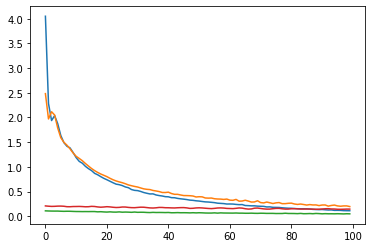

In [20]:
base_net.trainable = False
finalModel = Sequential([
                          base_net,
                          Dropout(0.2),
                          Dense(units=512, activation='relu', kernel_regularizer='l2'),
                          #Dense(units=128, activation='relu'),
                          Dropout(0.2),
                          Dense(units=1)
  ])
train_features = pd.read_csv(filepath + '/train_features.csv')
train_labels = pd.read_csv(filepath + './train_labels.csv')
X = train_features.drop(['Id', 'smiles'], axis=1)
y = train_labels.drop(['Id'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
finalModel.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = finalModel.fit(X,y, epochs=100,  validation_split=0.1, shuffle=True)

y_pred = finalModel.predict(X_test)
display(mean_squared_error(y_test,y_pred, squared=False))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

base_net.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
finalModel.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = finalModel.fit(X,y, epochs=100,  validation_split=0.1, shuffle=True)

y_pred = finalModel.predict(X_test)
display(mean_squared_error(y_test,y_pred, squared=False))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
finalModel.save(filepath+'goodCandidate')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/STUDIUM/Studium 2022 FS/Machine Learning/Projects/Project 4/goodCandidate/assets


In [ ]:
test_features = pd.read_csv(filepath + '/test_features.csv')

predictions = pd.DataFrame()
predictions['Id'] = test_features['Id']
test_features = test_features.drop(['Id', 'smiles'], axis=1)
predictions['y'] = finalModel.predict(test_features)
#predictions = predictions.drop(predictions.columns[0], axis=1)
display(predictions.head(30))
predictions.to_csv(filepath+'predictions.csv', index=False)

# Oversampling using SMOTE

In [ ]:
!pip install smogn

In [ ]:
import smogn

train_features = pd.read_csv(filepath + '/train_features.csv')
train_labels = pd.read_csv(filepath + './train_labels.csv')
X = train_features.drop(['Id', 'smiles'], axis=1)
y = train_labels.drop(['Id'],axis=1)

allData = pd.concat([X,y], axis=1)

oversampledData = smogn.smoter(data=allData,y='homo_lumo_gap')

r_index: 100%|##########| 11/11 [00:00<00:00, 14.95it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
SMOGNModel = Sequential([
                          base_net,
                          Dense(units=128, activation='relu'),
                          #Dense(units=128, activation='relu'),
                          Dense(units=1)
  ])
y = oversampledData['homo_lumo_gap']
X = oversampledData.drop(['homo_lumo_gap'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, random_state=42, shuffle=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
SMOGNModel.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

SMOGNModel.fit(X_train,y_train, epochs=10, callbacks=[es], validation_split=0.04)

y_pred = SMOGNModel.predict(X_test)
display(mean_squared_error(y_test,y_pred, squared=False))

Epoch 1/10
3/3 [==============================] - 1s 85ms/step - loss: 4.5982 - root_mean_squared_error: 2.1444 - val_loss: 2.9853 - val_root_mean_squared_error: 1.7278
Epoch 2/10
3/3 [==============================] - 0s 18ms/step - loss: 2.8690 - root_mean_squared_error: 1.6938 - val_loss: 1.6108 - val_root_mean_squared_error: 1.2692
Epoch 3/10
3/3 [==============================] - 0s 22ms/step - loss: 1.5771 - root_mean_squared_error: 1.2558 - val_loss: 0.7242 - val_root_mean_squared_error: 0.8510
Epoch 4/10
3/3 [==============================] - 0s 18ms/step - loss: 0.7606 - root_mean_squared_error: 0.8721 - val_loss: 0.2865 - val_root_mean_squared_error: 0.5353
Epoch 5/10
3/3 [==============================] - 0s 15ms/step - loss: 0.4037 - root_mean_squared_error: 0.6354 - val_loss: 0.2137 - val_root_mean_squared_error: 0.4623
Epoch 6/10
3/3 [==============================] - 0s 16ms/step - loss: 0.4368 - root_mean_squared_error: 0.6609 - val_loss: 0.3280 - val_root_mean_squared_

0.19720051188390583

In [ ]:
test_features = pd.read_csv(filepath + '/test_features.csv')

predictions = pd.DataFrame()
predictions['Id'] = test_features['Id']
test_features = test_features.drop(['Id', 'smiles'], axis=1)
predictions['y'] = SMOGNModel.predict(test_features)
#predictions = predictions.drop(predictions.columns[0], axis=1)
display(predictions.head(20))
predictions.to_csv(filepath+'predictions.csv', index=False)